# Imports

In [112]:
"""
Section 4: PyTorch Neural Network Classification
"""
import torch
import torchmetrics
from sklearn.datasets import make_circles, make_blobs
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as panda
from torch import nn
from pathlib import Path
import matplotlib.pyplot as plt
import requests

In [27]:

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

torch.__version__

helper_functions.py already exists, skipping download


'1.13.1'

# Make a toy dataset

In [3]:
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [4]:
len(X), len(y)

(1000, 1000)

In [5]:
circles = panda.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


## plot the dataset

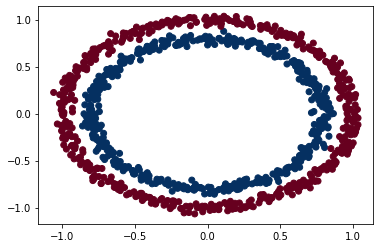

In [6]:
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdBu)
plt.show()

## convert from numpy to torch.tensor

In [7]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

## Split between test & train

In [8]:
# X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [9]:
len(X_train), len(y_train)

(800, 800)

In [10]:
len(X_test), len(y_test)

(200, 200)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Create the model

In [12]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))


model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

# Create a nn.sequential

In [13]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [14]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1462,  0.3592],
                      [-0.0009, -0.6133],
                      [ 0.4427,  0.3021],
                      [ 0.0377, -0.6793],
                      [ 0.0693,  0.0712]])),
             ('0.bias', tensor([-0.7058, -0.3973,  0.0020, -0.1061,  0.0764])),
             ('1.weight',
              tensor([[-0.0087,  0.0235,  0.0090, -0.2263,  0.2307]])),
             ('1.bias', tensor([0.2618]))])

In [15]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.4016],
        [0.4496],
        [0.2425],
        [0.4468],
        [0.1899],
        [0.2196],
        [0.3966],
        [0.3426],
        [0.2449],
        [0.4522]])

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


# Set up a loss function & optimizer

In [16]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.1
)

In [17]:
def accuracy_fn(y_true, _y_predicted):
    correct = torch.eq(y_true, _y_predicted).sum().item()
    accuracy = (correct / len(_y_predicted)) * 100
    return accuracy

In [18]:
# The logits
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.4016],
        [0.4496],
        [0.2425],
        [0.4468],
        [0.1899]])

In [19]:
# prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5991],
        [0.6105],
        [0.5603],
        [0.6099],
        [0.5473]])

In [20]:
# predicted labels
y_preds = torch.round(y_pred_probs)

# logits -> pred probs -> pred labels
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

# Build a training & testing loop

In [21]:
torch.manual_seed(42)
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    # 1. forward pass
    # logits -> predicted probabilities -> prediction labels
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss
    # calculate loss & accuracy, nn.BCEWithLogitsLoss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_predicted=y_pred)

    # 3. Zero out the gradients
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Optimization (gradient descent)
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_0(X_test).squeeze()
        test_predictions = torch.round(torch.sigmoid(test_logits))

        # calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_predicted=test_predictions)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}\n | Loss: {loss}, Accuracy: {acc:.2f}%"
              f"\n | Test loss: {test_loss:.2f}, Test acc: {test_acc:.2f}%")

Epoch: 0
 | Loss: 0.70453280210495, Accuracy: 50.00%
 | Test loss: 0.71, Test acc: 50.00%
Epoch: 10
 | Loss: 0.6978817582130432, Accuracy: 50.00%
 | Test loss: 0.70, Test acc: 50.00%
Epoch: 20
 | Loss: 0.6951332688331604, Accuracy: 55.25%
 | Test loss: 0.70, Test acc: 56.00%
Epoch: 30
 | Loss: 0.6939865946769714, Accuracy: 54.62%
 | Test loss: 0.70, Test acc: 49.50%
Epoch: 40
 | Loss: 0.6934981346130371, Accuracy: 52.50%
 | Test loss: 0.70, Test acc: 50.00%
Epoch: 50
 | Loss: 0.6932815313339233, Accuracy: 52.75%
 | Test loss: 0.70, Test acc: 48.00%
Epoch: 60
 | Loss: 0.6931787133216858, Accuracy: 51.62%
 | Test loss: 0.70, Test acc: 50.00%
Epoch: 70
 | Loss: 0.6931245923042297, Accuracy: 51.38%
 | Test loss: 0.70, Test acc: 49.50%
Epoch: 80
 | Loss: 0.6930927038192749, Accuracy: 51.12%
 | Test loss: 0.70, Test acc: 46.50%
Epoch: 90
 | Loss: 0.6930716633796692, Accuracy: 51.25%
 | Test loss: 0.70, Test acc: 46.50%


## Plot decision boundary of model

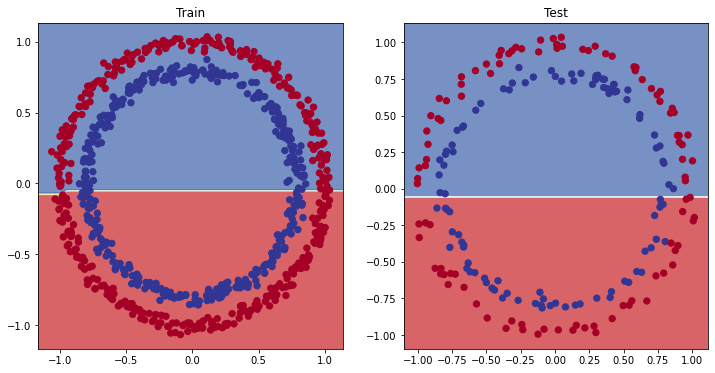

In [22]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# Circle Model v2

In [23]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        logit1 = self.layer_1(x)
        logit2 = self.layer_2(logit1)
        logit3 = self.layer_3(logit2)
        # or
        # self.layer_3(self.layer_2(self.layer_1(x)))
        return logit3


model_1 = CircleModelV2().to(device)
model_1

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

## Create a loss function & optimizer

In [24]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [25]:
torch.manual_seed(42)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    # 1. forward pass
    # logits -> predicted probabilities -> predicted labels
    y_logits = model_1(X_train).squeeze()
    y_predicted = torch.round(torch.sigmoid(y_logits))

    # 2. calculate loss & accuracy
    training_loss = loss_fn(y_logits, y_train)
    training_acc = accuracy_fn(y_true=y_train, y_predicted=y_predicted)

    # 3. zero out gradients
    optimizer.zero_grad()

    # 4. backpropagation
    training_loss.backward()

    # 5. optimization(gradient descent)
    optimizer.step()

    # Test
    model_1.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_1(X_test).squeeze()
        test_predictions = torch.round(torch.sigmoid(test_logits))
        # calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_fn(y_test, test_predictions)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}\n | Training Loss: {training_loss}, Training Accuracy: {training_acc:.2f}%"
              f"\n | Test Loss: {test_loss:.2f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0
 | Training Loss: 0.6939550638198853, Training Accuracy: 50.88%
 | Test Loss: 0.69, Test Accuracy: 47.00%
Epoch: 100
 | Training Loss: 0.6930477619171143, Training Accuracy: 50.38%
 | Test Loss: 0.69, Test Accuracy: 47.00%
Epoch: 200
 | Training Loss: 0.692986011505127, Training Accuracy: 51.12%
 | Test Loss: 0.69, Test Accuracy: 47.00%
Epoch: 300
 | Training Loss: 0.6929805278778076, Training Accuracy: 51.62%
 | Test Loss: 0.69, Test Accuracy: 47.00%
Epoch: 400
 | Training Loss: 0.6929798722267151, Training Accuracy: 51.12%
 | Test Loss: 0.69, Test Accuracy: 47.00%
Epoch: 500
 | Training Loss: 0.6929798722267151, Training Accuracy: 51.00%
 | Test Loss: 0.69, Test Accuracy: 47.00%
Epoch: 600
 | Training Loss: 0.6929798722267151, Training Accuracy: 51.00%
 | Test Loss: 0.69, Test Accuracy: 47.00%
Epoch: 700
 | Training Loss: 0.6929798126220703, Training Accuracy: 51.00%
 | Test Loss: 0.69, Test Accuracy: 47.00%
Epoch: 800
 | Training Loss: 0.6929798722267151, Training Accuracy:

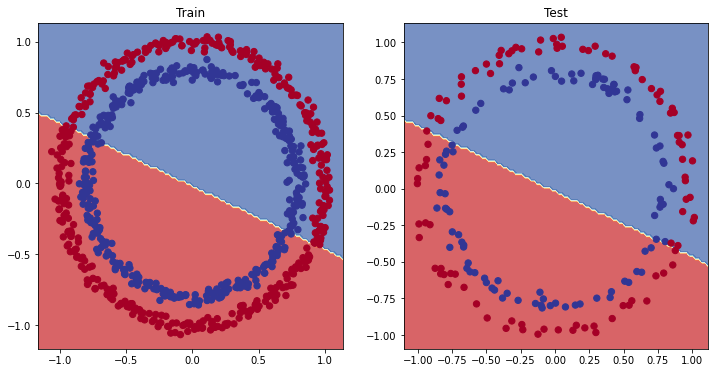

In [26]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

# Create straight line to see if model is learning

In [29]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias
print(X_regression[:5], '\n', y_regression[:5])

tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400]]) 
 tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280]])


## Train and Test split

In [32]:
train_split = int(.8 * len(X_regression))

# training data
X_train_r = X_regression[:train_split]
y_train_r = y_regression[:train_split]

# to check on unseen data
X_test_r = X_regression[train_split:]
y_test_r = y_regression[train_split:]

print(len(X_train_r), len(y_train_r))
print(len(X_test_r), len(y_test_r))

80 80
20 20


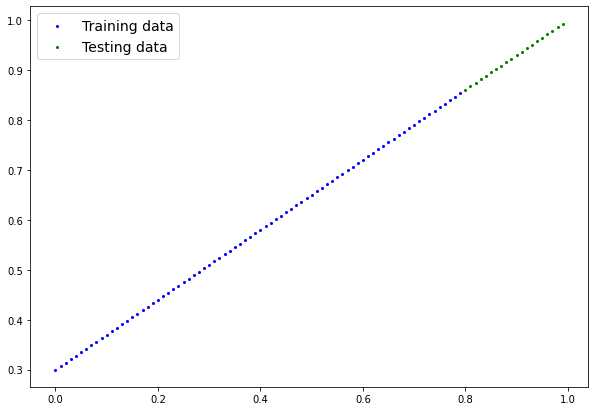

In [33]:
plot_predictions(train_data=X_train_r,
                 train_labels=y_train_r,
                 test_data=X_test_r,
                 test_labels=y_test_r)

In [34]:
model_1

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [35]:
print(X_train_r[:5])
print(y_train_r[:5])

tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400]])
tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280]])


## Make the model

In [36]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [43]:
# loss function & optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

## Train the model

In [44]:
torch.manual_seed(42)
epochs = 1000
# to teach
X_train_r = X_train_r.to(device)
y_train_r = y_train_r.to(device)
# to test
X_test_r = X_test_r.to(device)
y_test_r = y_test_r.to(device)

for epoch in range(epochs):
    # forward
    y_predictions = model_2(X_train_r)

    # loss
    loss = loss_fn(y_predictions, y_train_r)

    # zero
    optimizer.zero_grad()

    # back
    loss.backward()

    # optim
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_predictions = model_2(X_test_r)
        test_loss = loss_fn(test_predictions, y_test_r)

    if epoch % 100 == 0:
        print(f"epoch: {epoch} | training loss: {loss} | test loss: {test_loss}")

epoch: 0 | training loss: 0.06454748660326004 | test loss: 0.12449244409799576
epoch: 100 | training loss: 0.006964639760553837 | test loss: 0.0010862589115276933
epoch: 200 | training loss: 0.006350597832351923 | test loss: 0.001208081841468811
epoch: 300 | training loss: 0.006036859471350908 | test loss: 0.0009791136253625154
epoch: 400 | training loss: 0.00632986705750227 | test loss: 0.0016628056764602661
epoch: 500 | training loss: 0.006310972385108471 | test loss: 0.001365217613056302
epoch: 600 | training loss: 0.006291779689490795 | test loss: 0.0010971457231789827
epoch: 700 | training loss: 0.0065868450328707695 | test loss: 0.0015957176219671965
epoch: 800 | training loss: 0.006271840073168278 | test loss: 0.001480054808780551
epoch: 900 | training loss: 0.006253449711948633 | test loss: 0.0011784166563302279


## Plot the predictions

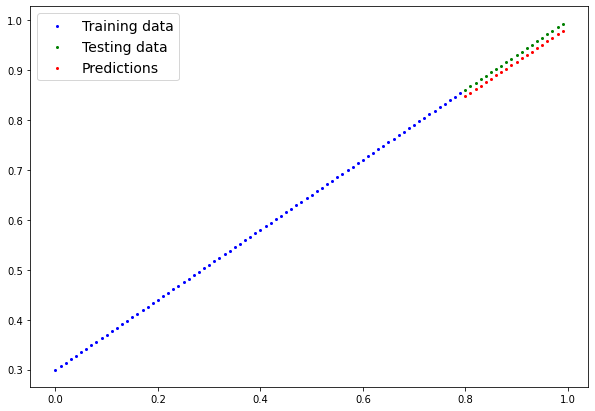

In [45]:
model_2.eval()

with torch.inference_mode():
    y_predictions2 = model_2(X_test_r)

plot_predictions(train_data=X_train_r,
                 train_labels=y_train_r,
                 test_data=X_test_r,
                 test_labels=y_test_r,
                 predictions=y_predictions2)

# Re-create make cirles

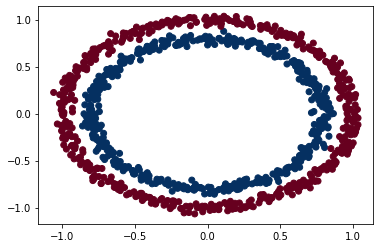

In [48]:
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)
plt.show()

In [0]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(len(X_train), len(y_train), len(X_test), len(y_test))
print(X_train[:5])
print(y_train[:5])

800 800 200 200
tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        [-0.9666, -0.2256],
        [-0.1666,  0.7994]])
tensor([1., 0., 0., 0., 1.])


# Build a Circle model

In [55]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        l1 = self.layer1(x)
        l2 = self.relu(l1)
        l3 = self.layer2(l2)
        l4 = self.relu(l3)
        l5 = self.layer3(l4)
        # - or -
        # self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
        return l5


model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

## Set up Loss fn & Optimizer

In [59]:
loss_fn = nn.BCEWithLogitsLoss()  # because this is binary classification
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

## Train the model

In [61]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_3.train()

    # 1. forward
    logits = model_3(X_train).squeeze()
    # logits -> prediction probabilities -> prediction labels
    training_prediction = torch.round(torch.sigmoid(logits))

    # 2. loss
    loss = loss_fn(logits, y_train)
    acc = accuracy_fn(y_train, training_prediction)

    # 3. zero
    optimizer.zero_grad()

    # 4. back
    loss.backward()

    # 5. optim
    optimizer.step()

    # ~ test ~
    model_3.eval()
    with torch.inference_mode():
        # forward
        test_logits = model_3(X_test).squeeze()
        test_prediction = torch.round(torch.sigmoid(test_logits))
        # loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_prediction)

    if epoch % 100 == 0:
        print(f'epoch: {epoch} | train loss, acc: {loss:.4f}, {acc:.2f}%'
              f' | test loss, acc: {test_loss:.4f}, {test_acc:.2f}%')

epoch: 0 | train loss, acc: 0.6929, 50.00% | test loss, acc: 0.6932, 50.00%
epoch: 100 | train loss, acc: 0.6912, 52.88% | test loss, acc: 0.6910, 52.50%
epoch: 200 | train loss, acc: 0.6898, 53.37% | test loss, acc: 0.6894, 55.00%
epoch: 300 | train loss, acc: 0.6879, 53.00% | test loss, acc: 0.6872, 56.00%
epoch: 400 | train loss, acc: 0.6852, 52.75% | test loss, acc: 0.6841, 56.50%
epoch: 500 | train loss, acc: 0.6810, 52.75% | test loss, acc: 0.6794, 56.50%
epoch: 600 | train loss, acc: 0.6751, 54.50% | test loss, acc: 0.6729, 56.00%
epoch: 700 | train loss, acc: 0.6666, 58.38% | test loss, acc: 0.6632, 59.00%
epoch: 800 | train loss, acc: 0.6516, 64.00% | test loss, acc: 0.6476, 67.50%
epoch: 900 | train loss, acc: 0.6236, 74.00% | test loss, acc: 0.6215, 79.00%


In [56]:
model_3.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1310

In [62]:
model_3.eval()
with torch.inference_mode():
    logit = model_3(X_test).squeeze()
    y_prediction = torch.round(torch.sigmoid(logit))

print(y_prediction[:10])
print(y_test[:10])

tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.])
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


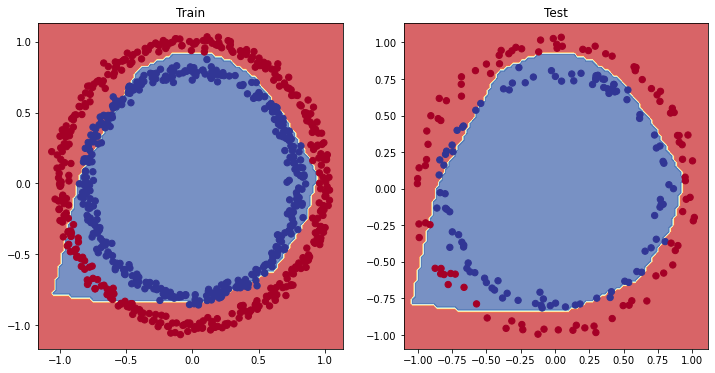

In [63]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)
plt.show()

# Replicating non-linear activation functions

In [66]:
# create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

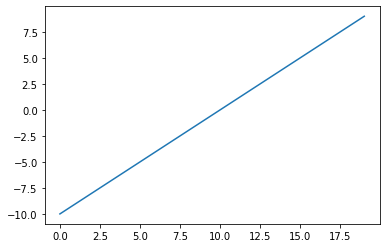

In [68]:
plt.plot(A)
plt.show()

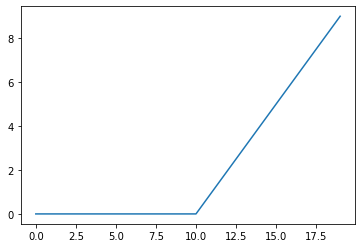

In [69]:
plt.plot(torch.relu(A))
plt.show()

In [70]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.max(torch.tensor(0), x)

In [72]:
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

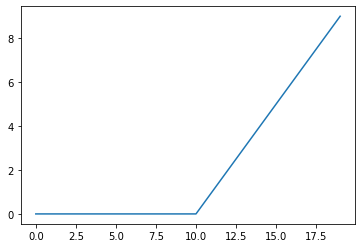

In [74]:
plt.plot(relu(A))
plt.show()

In [75]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))

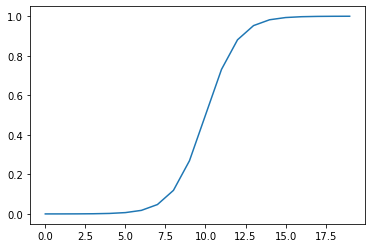

In [76]:
plt.plot(torch.sigmoid(A))
plt.show()

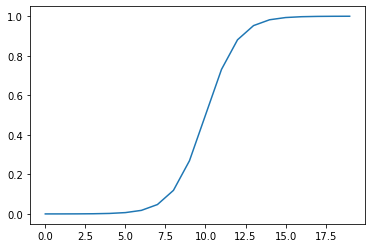

In [77]:
plt.plot(sigmoid(A))
plt.show()

# Multi-class classification

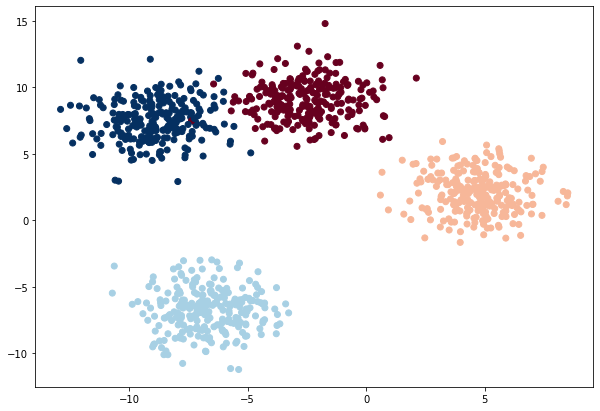

In [94]:
# hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# convert to tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# train test split the data
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdBu)
plt.show()

In [95]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cpu'

## The blob model

In [96]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        init a multi-class classification
        :param input_features:
        :param output_features: number of output classes
        :param hidden_units:
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

## Loss fn & optimizer

In [97]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

In [98]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

## convert logits to SoftMax

In [99]:
# logit -> prediction probability
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:10])
print(y_pred_probs[:10])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463],
        [0.3381, 0.1358, 0.1929, 0.3331],
        [0.2867, 0.1841, 0.2861, 0.2431],
        [0.3554, 0.1355, 0.1740, 0.3351],
        [0.3009, 0.1841, 0.2779, 0.2371],
        [0.3595, 0.1350, 0.1695, 0.3360]])


In [100]:
# prediction probability -> prediction label
y_pred_labels = torch.argmax(y_pred_probs, dim=1)
y_pred_labels

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

## Create a multi-class training & testing loop

In [105]:
torch.manual_seed(42)
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    # forward
    y_logits = model_4(X_blob_train)
    y_predictions = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # loss
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_blob_train, y_predictions)

    # zero
    optimizer.zero_grad()

    # back
    loss.backward()

    # optimize
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_predictions = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_blob_test, test_predictions)

    if epoch % 10 == 0:
        print(f'epoch {epoch} | train: {loss:.4f} {acc:.2f}% | test: {test_loss:.4f} {test_acc:.2f}%')

epoch 0 | train: 0.0223 99.25% | test: 0.0109 99.50%
epoch 10 | train: 0.0223 99.25% | test: 0.0109 99.50%
epoch 20 | train: 0.0222 99.25% | test: 0.0109 99.50%
epoch 30 | train: 0.0222 99.25% | test: 0.0109 99.50%
epoch 40 | train: 0.0222 99.25% | test: 0.0108 99.50%
epoch 50 | train: 0.0222 99.25% | test: 0.0108 99.50%
epoch 60 | train: 0.0222 99.25% | test: 0.0108 99.50%
epoch 70 | train: 0.0221 99.25% | test: 0.0108 99.50%
epoch 80 | train: 0.0221 99.25% | test: 0.0108 99.50%
epoch 90 | train: 0.0221 99.25% | test: 0.0107 99.50%


## Visualize the predictions

In [106]:
model_4.eval()

with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[ -2.5221,  11.1839, -10.2721, -11.4082],
        [ -2.1227,  -9.6463,  -6.4508,   5.2757],
        [ -4.9936,  -5.3849,   5.4574,  -4.3761],
        [ -3.1822,   8.3688,  -5.5522,  -6.7527],
        [  6.5797,  -3.0410, -12.4417,  -8.4402],
        [ -2.7287, -11.3915,  -7.6212,   6.4908],
        [ -4.3631,  -4.5820,   4.7488,  -3.6451],
        [  5.8638,  -6.9468,  -9.8651,  -4.1093],
        [ -6.3959,  -6.9384,   6.7614,  -5.6073],
        [  6.3901,  -5.7105, -10.4605,  -5.4375]])

In [107]:
# logits -> prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.1158e-06, 1.0000e+00, 4.8062e-10, 1.5432e-10],
        [6.1184e-04, 3.3052e-07, 8.0717e-06, 9.9938e-01],
        [2.8917e-05, 1.9552e-05, 9.9990e-01, 5.3620e-05],
        [9.6263e-06, 9.9999e-01, 8.9985e-07, 2.7091e-07],
        [9.9993e-01, 6.6336e-05, 5.4840e-09, 2.9984e-07],
        [9.9084e-05, 1.7131e-08, 7.4335e-07, 9.9990e-01],
        [1.1030e-04, 8.8611e-05, 9.9957e-01, 2.2614e-04],
        [9.9995e-01, 2.7317e-06, 1.4758e-07, 4.6640e-05],
        [1.9313e-06, 1.1227e-06, 9.9999e-01, 4.2496e-06],
        [9.9999e-01, 5.5562e-06, 4.8069e-08, 7.2999e-06]])

In [109]:
# prediction probabilities
y_predictions = torch.argmax(y_pred_probs, dim=1)
y_predictions

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [110]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

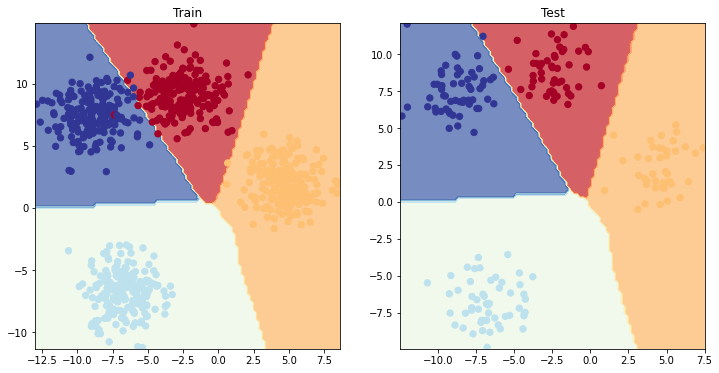

In [111]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## Classification metrics

In [114]:
torchmetric_accuracy = torchmetrics.Accuracy('multiclass').to(device)
torchmetric_accuracy(y_predictions, y_blob_test)

AssertionError: 